# Read in Data

In [14]:
import os
import sys

current_dir = os.path.dirname(os.path.abspath('truth_extraction_sandbox.ipynb'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import util

def read_data():
    # load in the price data
    data_df = pd.read_csv('../data/btc_1m.csv')
    # compute the rate of return -- makes the price easier to track
    data_df['rate'] = (data_df['Open'].values - data_df['Open'].values[0]) / data_df['Open'].values[0]
    return data_df

df = read_data()
df.rate = (df.Open - df.Open.values[0]) / df.Open.values[0]
df.head()

,Date,Time,EpochTime,Open,High,Low,Close,Volume,rate
0,2025-07-31,02:15:00Z,1753928100,118230.01,118230.01,118200.01,118230.01,3.583388,0.000000
1,2025-07-31,02:16:00Z,1753928160,118230.01,118238.45,118215.00,118219.28,1.053575,0.000000
2,2025-07-31,02:17:00Z,1753928220,118219.32,118269.64,118215.00,118262.50,1.593586,-0.000090
3,2025-07-31,02:18:00Z,1753928280,118262.50,118267.98,118262.50,118267.98,0.337689,0.000275
4,2025-07-31,02:19:00Z,1753928340,118267.98,118267.98,118238.47,118242.06,0.522006,0.000321


# Understanding the FFT Spectrum

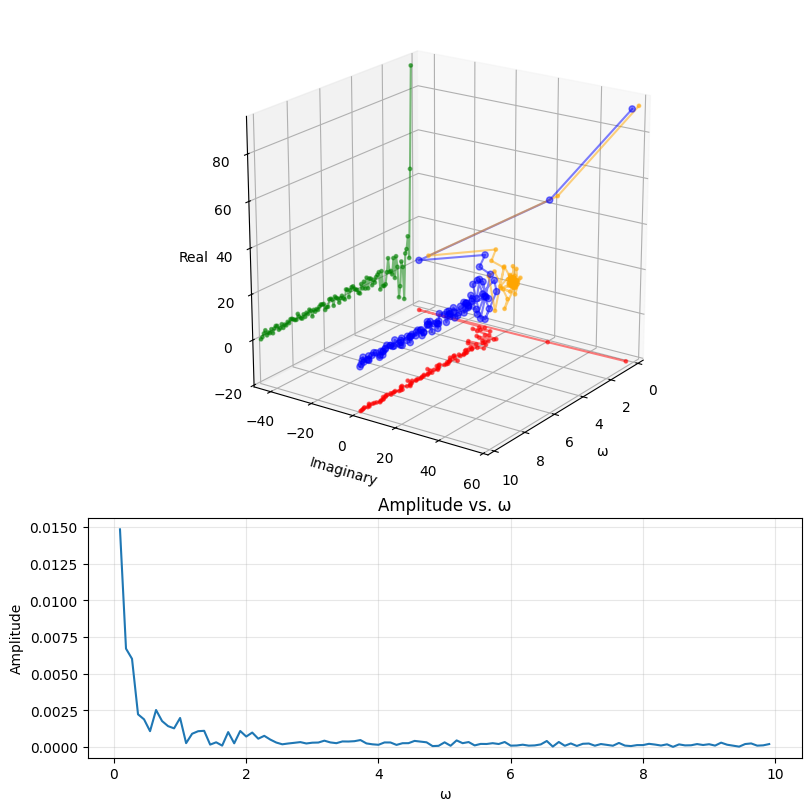

In [7]:
def plot_fft_space(fft_data_dict, omega_cap=None):
    def pad(v, f=0.05):
        vmin, vmax = float(np.min(v)), float(np.max(v))
        span = vmax - vmin if vmax > vmin else 1.0
        return vmin - f*span, vmax + f*span

    # get fft info
    omega, real, imag = fft_data_dict['freq'], fft_data_dict['fhat_real'], fft_data_dict['fhat_imag']
    # trim down on necessary values for demonstration
    if omega_cap is None:
        omega_cap = max(omega)
    idx_lim = (omega_cap > omega) & (omega > 0)
    omega, real, imag = omega[idx_lim], real[idx_lim], imag[idx_lim]

    # create plots to demonstration the spectrum
    fig = plt.figure(figsize=(8, 8), constrained_layout=True)
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1])

    ax3d = fig.add_subplot(gs[0, 0], projection='3d')  # top
    ax2d = fig.add_subplot(gs[1, 0])                   # bottom

    # Equal scaling for an isometric look (Matplotlib ≥ 3.3)
    ax3d.set_box_aspect([1, 1, 1])

    # Axis labels
    ax3d.set_xlabel('ω')
    ax3d.set_ylabel('Imaginary')
    ax3d.set_zlabel('Real')

    # Nice viewing angle (tweak as needed)
    ax3d.view_init(elev=20, azim=35)

    # definte boundaries to make the most aesthetically pleasing plot
    x = omega
    y = imag
    z = real
    xmin, xmax = pad(x)
    ymin, ymax = pad(y)
    zmin, zmax = pad(z)
    ax3d.set_xlim(xmin, xmax)
    ax3d.set_ylim(ymin, ymax)
    ax3d.set_zlim(zmin, zmax)

    # ---- 3D isometric scatter: (omega, real, imag) ----
    ax3d.plot(x, y, z, alpha=.5, color='blue')# , s=8)
    ax3d.scatter(x, y, z, alpha=.5, color='blue')

    # Projections:
    # 1) onto XY plane at z = zmin
    ax3d.scatter(x, y, np.full_like(z, zmin), s=6, alpha=0.5, color='red')
    ax3d.plot(x, y, np.full_like(z, zmin), alpha=0.5, color='red')

    # 2) onto XZ plane at y = ymin
    ax3d.scatter(x, np.full_like(y, ymin), z, s=6, alpha=0.5, color='green')
    ax3d.plot(x, np.full_like(y, ymin), z, alpha=0.5, color='green')

    # 3) onto YZ plane at x = xmin
    ax3d.scatter(np.full_like(x, xmin), y, z, s=6, alpha=0.5, color='orange')
    ax3d.plot(np.full_like(x, xmin), y, z, alpha=0.5, color='orange')

    # ---- 2D plot: amplitude vs. omega ----
    ax2d.plot(omega, fft_data_dict['amp'][idx_lim], linewidth=1.5)
    # Optionally, emphasize samples:
    # ax2d.scatter(omega, amplitude, s=6)

    ax2d.set_xlabel('ω')
    ax2d.set_ylabel('Amplitude')
    ax2d.set_title('Amplitude vs. ω')
    ax2d.grid(True, alpha=0.3)

    plt.show()

# extract the full FFT
dt = len(df.Date.unique()) / len(df)
fft_data = util.full_fft_extract(df.rate.values, dt)

# plot it
plot_fft_space(fft_data, omega_cap=10)

# Understanding the Fast Fourier Transform Filtering

Change the `max_freq` term to attenuate ground truth extraction. The higher this term, the more sensitive the extraction process

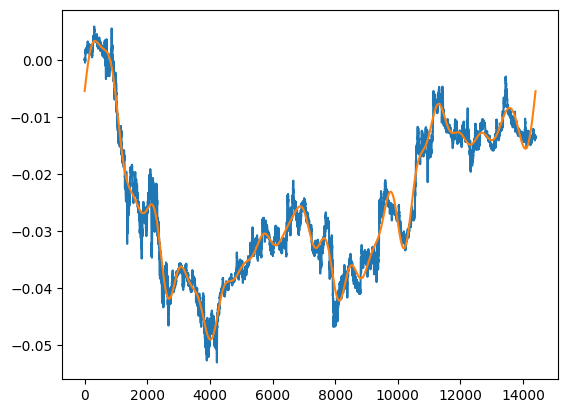

In [8]:
dt = len(df.Date.unique()) / len(df)
max_freq = 2
fft_data = util.extract_low_pass_components(df.rate.values, dt, max_freq=max_freq)

plt.plot(fft_data['raw'])
plt.plot(fft_data['truth'])

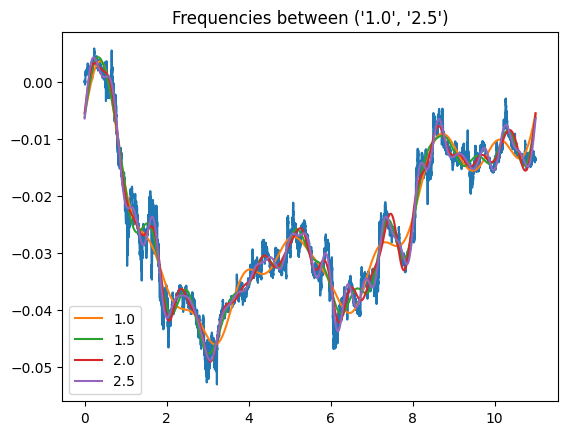

In [10]:
# Multiple signals!
t = np.arange(0, len(fft_data['raw'])) * dt
plt.plot(t, fft_data['raw'])

freq_ceils = np.arange(1, 2.6, .5)
for f in freq_ceils:
    fft_data = util.extract_low_pass_components(df.rate.values, dt, max_freq=f)
    plt.plot(t, fft_data['truth'], label=f'{f:.4}')

plt.title(f'Frequencies between {str(min(freq_ceils)), str(max(freq_ceils))}')
plt.legend()

# Test Extrema Labeling

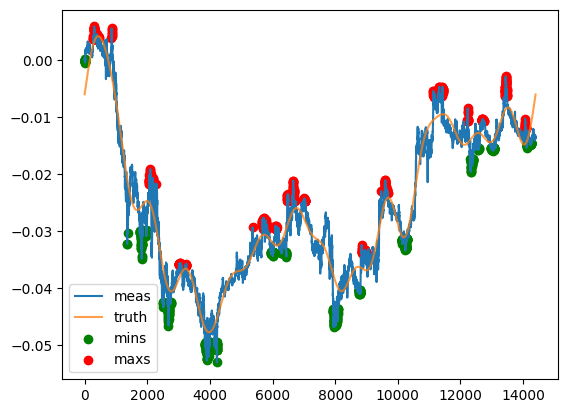

In [11]:
from Labelling.ExtremaCluster import compute_cluster_dict

dt = len(df.Date.unique()) / len(df)
max_freq_ground_truth = 1.45
cluster_dict = compute_cluster_dict(df.rate.values, max_freq_ground_truth, cdf_thresh=.95, dt=dt)

# make the plot
plt.plot(df.rate.values)
plt.plot(cluster_dict['fft_dict']['truth'], alpha=.75)
plt.scatter(np.concatenate(cluster_dict['cluster_min']['x_points']), np.concatenate(cluster_dict['cluster_min']['y_points']), color='green')
plt.scatter(np.concatenate(cluster_dict['cluster_max']['x_points']), np.concatenate(cluster_dict['cluster_max']['y_points']), color='red')
plt.legend(['meas', 'truth', 'mins', 'maxs'])

# Plot Filter State/Dynamics and Labels

In [12]:
from kalman_filter_bank.filter_bank import SinusoidalCMMEAFilterBank, run_filter_bank

def plot_filter_labels(meas, bank_dict, cluster_dict, dt):
    # find the x axis values of the feature labels
    extrema_points = np.concatenate((np.concatenate(cluster_dict['cluster_min']['x_points']), np.concatenate(cluster_dict['cluster_max']['x_points'])))

    # extract values
    bank_x = bank_dict['x']
    amp = bank_dict['amp']
    phase = bank_dict['phi']

    # plot filter estimates and system dynamics
    t = np.arange(0, len(meas)*dt, dt)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # position
    axs[0, 0].scatter(t, meas, color='red', s=5)
    axs[0, 0].scatter(t[extrema_points], meas[extrema_points], color='blue', s=5)
    axs[0, 0].plot(t, bank_x[:, 0], color='k')
    axs[0, 0].set_title(f'Position Estimation')

    # velocity
    axs[1, 0].plot(t, bank_x[:, 1], color='k')
    axs[1, 0].plot((t[0], t[-1]), (0, 0))
    axs[1, 0].scatter(t[extrema_points], bank_x[extrema_points, 1], color='blue')
    axs[1, 0].set_title(f'Velocity Estimation')

    # amplitude
    times_at = t[extrema_points]
    weighted_amp = amp * bank_dict['w']
    amps_at = weighted_amp[extrema_points, :]
    axs[0, 1].plot(t, weighted_amp)
    axs[0, 1].scatter(np.repeat(times_at, amps_at.shape[1]), amps_at.flatten(), color='k', alpha=.75)
    axs[0, 1].set_title(f'Amplitude Estimation')

    # phase
    abs_phase = np.abs(phase)[extrema_points, :]
    axs[1, 1].plot(t, np.abs(phase))
    axs[1, 1].scatter(np.repeat(times_at, abs_phase.shape[1]), abs_phase.flatten(), color='k', alpha=.75)
    axs[1, 1].set_title(f'(Absolute) Phase Estimation')

Running the Filter Bank for 14400 steps


100%|██████████| 14400/14400 [00:07<00:00, 1848.85it/s]


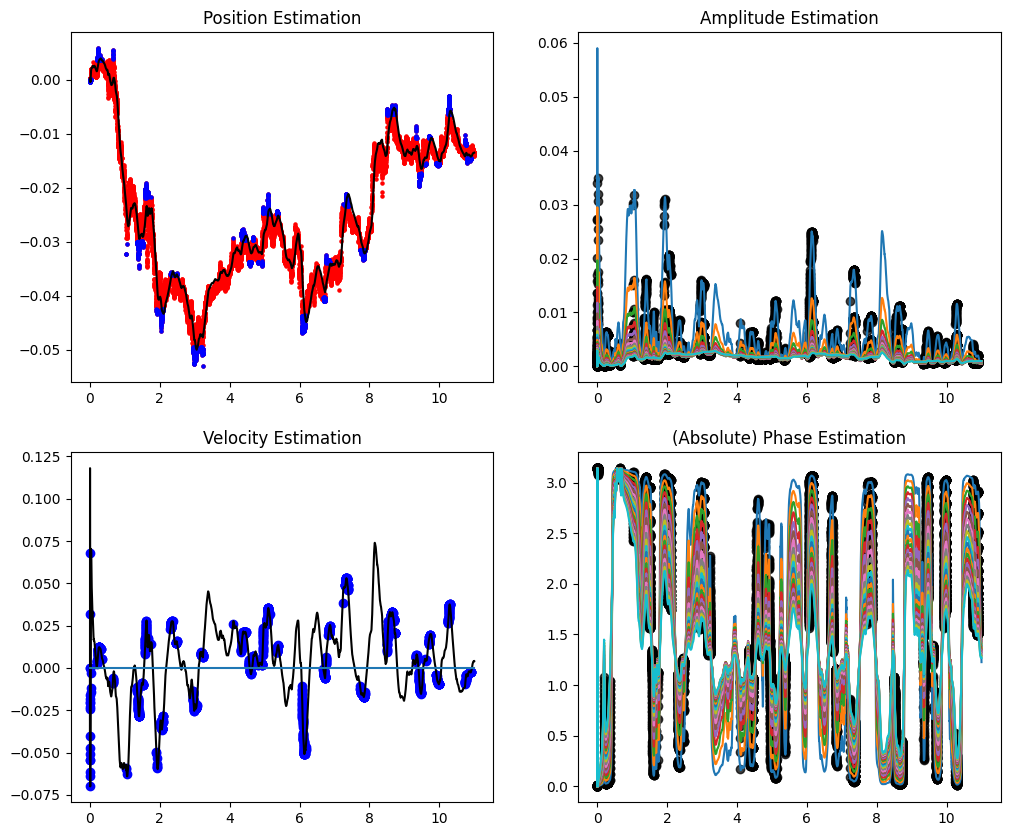

In [13]:
# build the CMMEA
d_omega = .1
omega_arr = np.arange(d_omega, 2+d_omega, d_omega)
cmmea_sigXi = [1e1]*len(omega_arr)
cmmea_rho = [1e-2]*len(omega_arr)
dt_cmmea = len(df.Date.unique()) / len(df)
cmmea = SinusoidalCMMEAFilterBank(2, 1, omegas=omega_arr, dt=dt_cmmea, sigma_xi=cmmea_sigXi, rho=cmmea_rho)

# run the CMMEA
cmmea_dict = run_filter_bank(cmmea, df.rate.values)

# Create Labels
dt = len(df.Date.unique()) / len(df)
max_freq = 1.45
cluster_dict = compute_cluster_dict(df.rate.values, max_freq, cdf_thresh=.95, dt=dt)


# plot
plot_filter_labels(df.rate.values, cmmea_dict, cluster_dict, dt)